In [1]:
import scvelo as scv
import scanpy as sc, numpy as np, pandas as pd, anndata as ad

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)

# Step 1: Load Data

In [3]:
adata = sc.read_h5ad('../data/processed/cells_postprocessed.h5ad')

In [4]:
# load loom files for spliced/unspliced matrices
ldata = scv.read('../data/processed/Pituitary_velocyto_all.loom', cache=True)
ldata.var_names_make_unique()

In [5]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [17]:
adata.obsm['X_umap']

UMAP_1     UMAP_2
TCTTCACA     -1.007439  13.386109
GATAGACA     -1.383246  13.435330
GCCACATA     -0.221990  -1.340649
TATCAGCA     -0.147930  -0.030428
TCCGTCTA     -5.610957   2.180710
...                ...        ...
TCTTCACA-125 -5.103109   2.042315
TGGAACAA-127  2.086688  -0.399138
TGGCTTCA-125  1.638088  -0.180058
TGGTGGTA-127 -1.224438   5.591853
TTCACGCA-128  1.886489  -0.136863

[5903 rows x 2 columns]

InvalidIndexError: (slice(None, None, None), (0, 1))

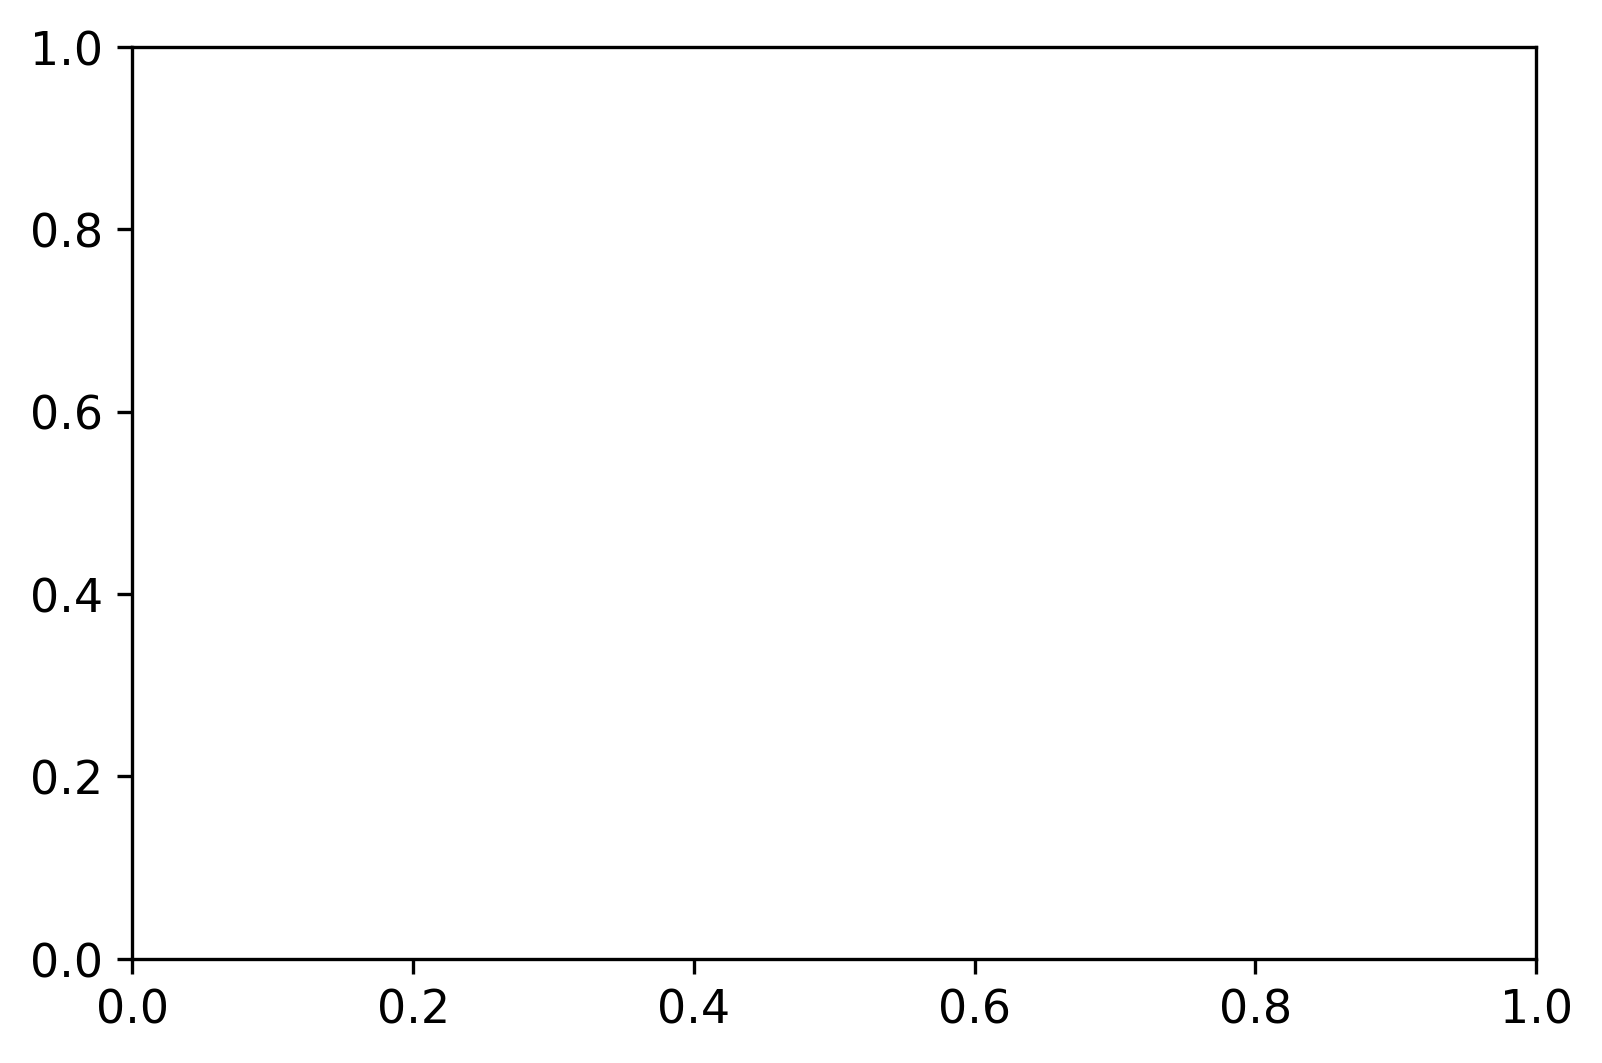

In [11]:
# plot umap to check
sc.pl.umap(adata, color='cell_type_brief', frameon=False, legend_loc='on data', title='')

In [ ]:
sc.pl.scatter(adata, color='cell_type_brief', frameon=False, legend_loc='on data', title='')

In [12]:
# subsetting anndata object
hdata = adata[adata.obs.cell_type_brief.isin(['Som','Lac','Cort','Mel','Gonad','Thyro'])]

In [13]:
hdata = hdata[hdata.obs.treat.isin(['Saline','LPS'])]

# Step 2-1: Recompute UMAP embedding

In [16]:
hdata['hvg']

KeyError: 'hvg'

In [30]:
sc.pp.log1p(hdata)

In [ ]:
sc.pp.highly_variable_genes(hdata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Step 2-2: Computing RNA velocity using scVelo

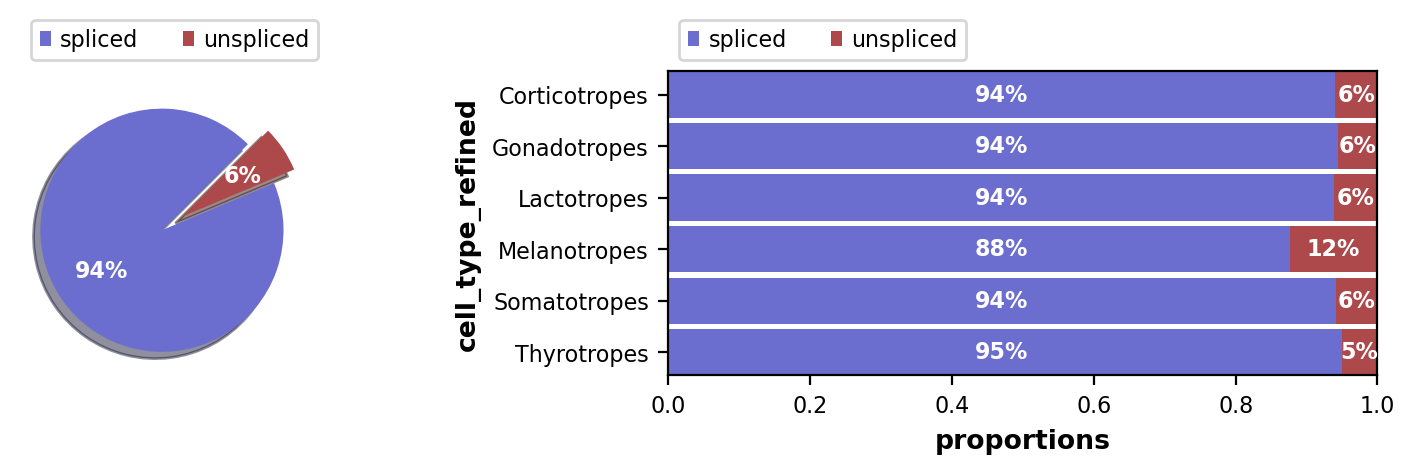

In [23]:
scv.pl.proportions(hdata, groupby='cell_type_refined')

In [24]:
# pre-process
scv.pp.filter_and_normalize(hdata)
scv.pp.moments(hdata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [25]:
# compute velocity
scv.tl.velocity(hdata, mode='stochastic')
scv.tl.velocity_graph(hdata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/48 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Step 2-3: Visualize velocity fields

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_embedding.pdf


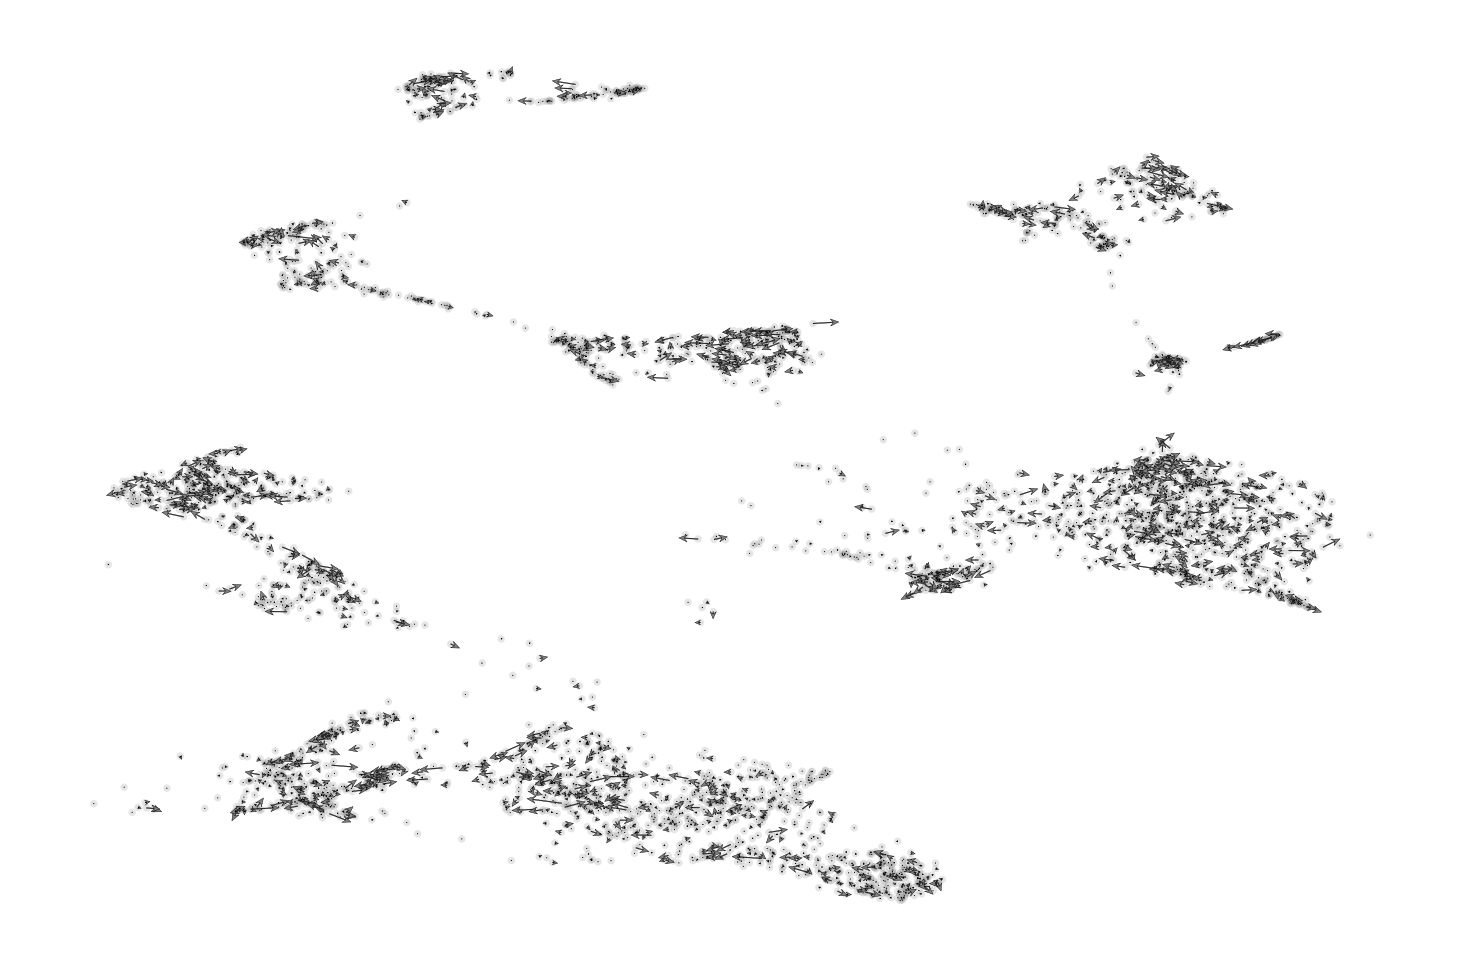

In [26]:
scv.pl.velocity_embedding(hdata, basis='umap', frameon=False, save='embedding.pdf')

saving figure to file ./figures/scvelo_embedding_grid.pdf


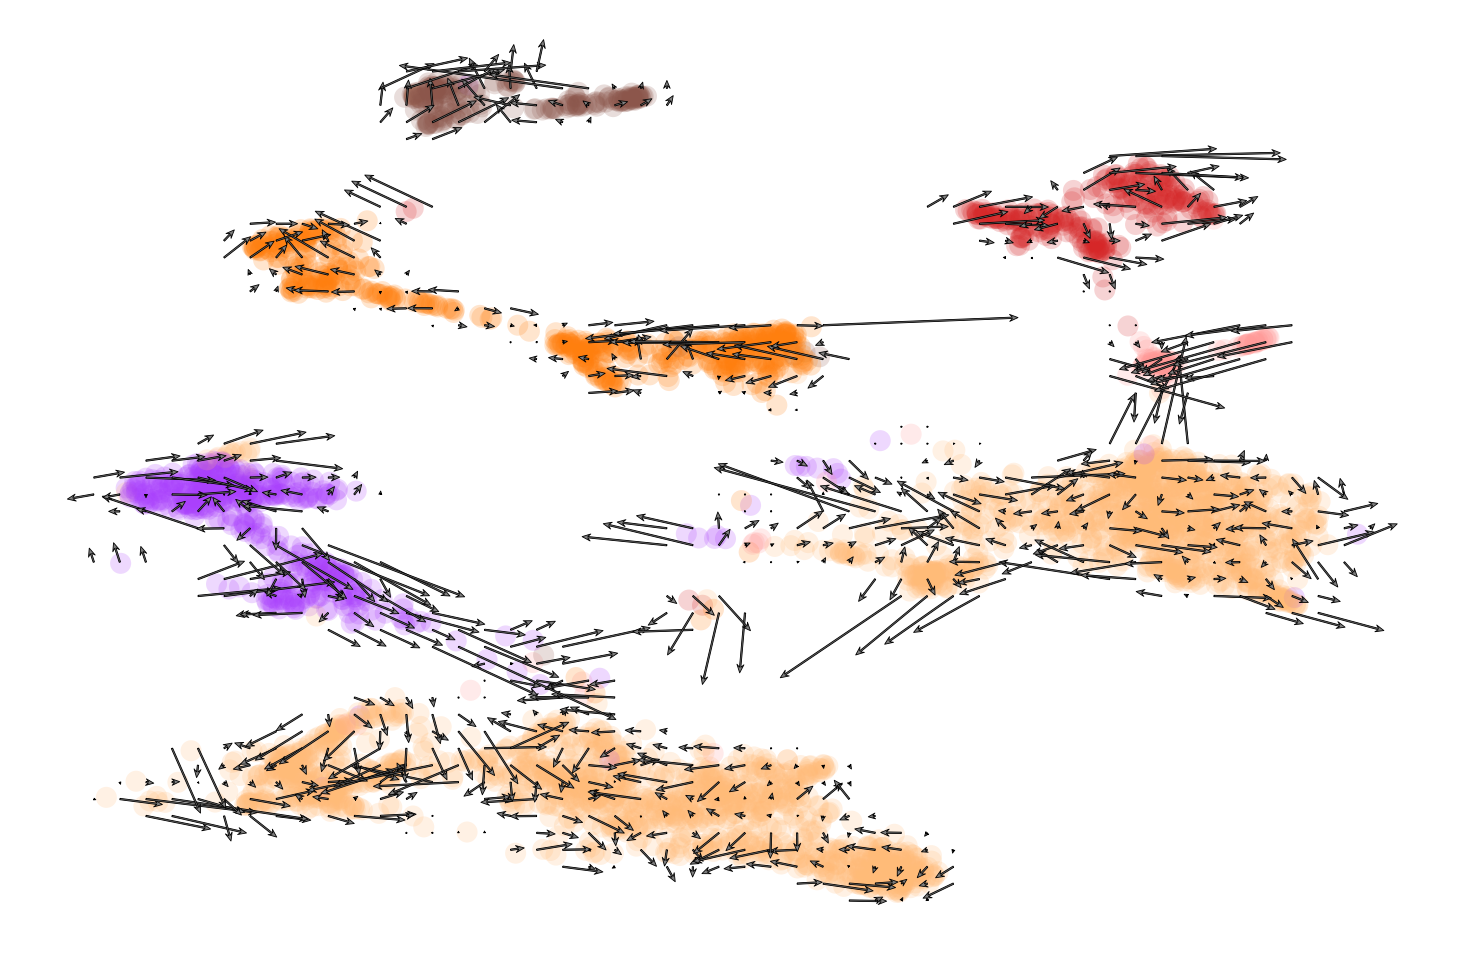

In [27]:
scv.pl.velocity_embedding_grid(hdata, basis='umap', color='cell_type_brief', save='embedding_grid.pdf', title='', scale=0.25)

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_embedding_stream.png


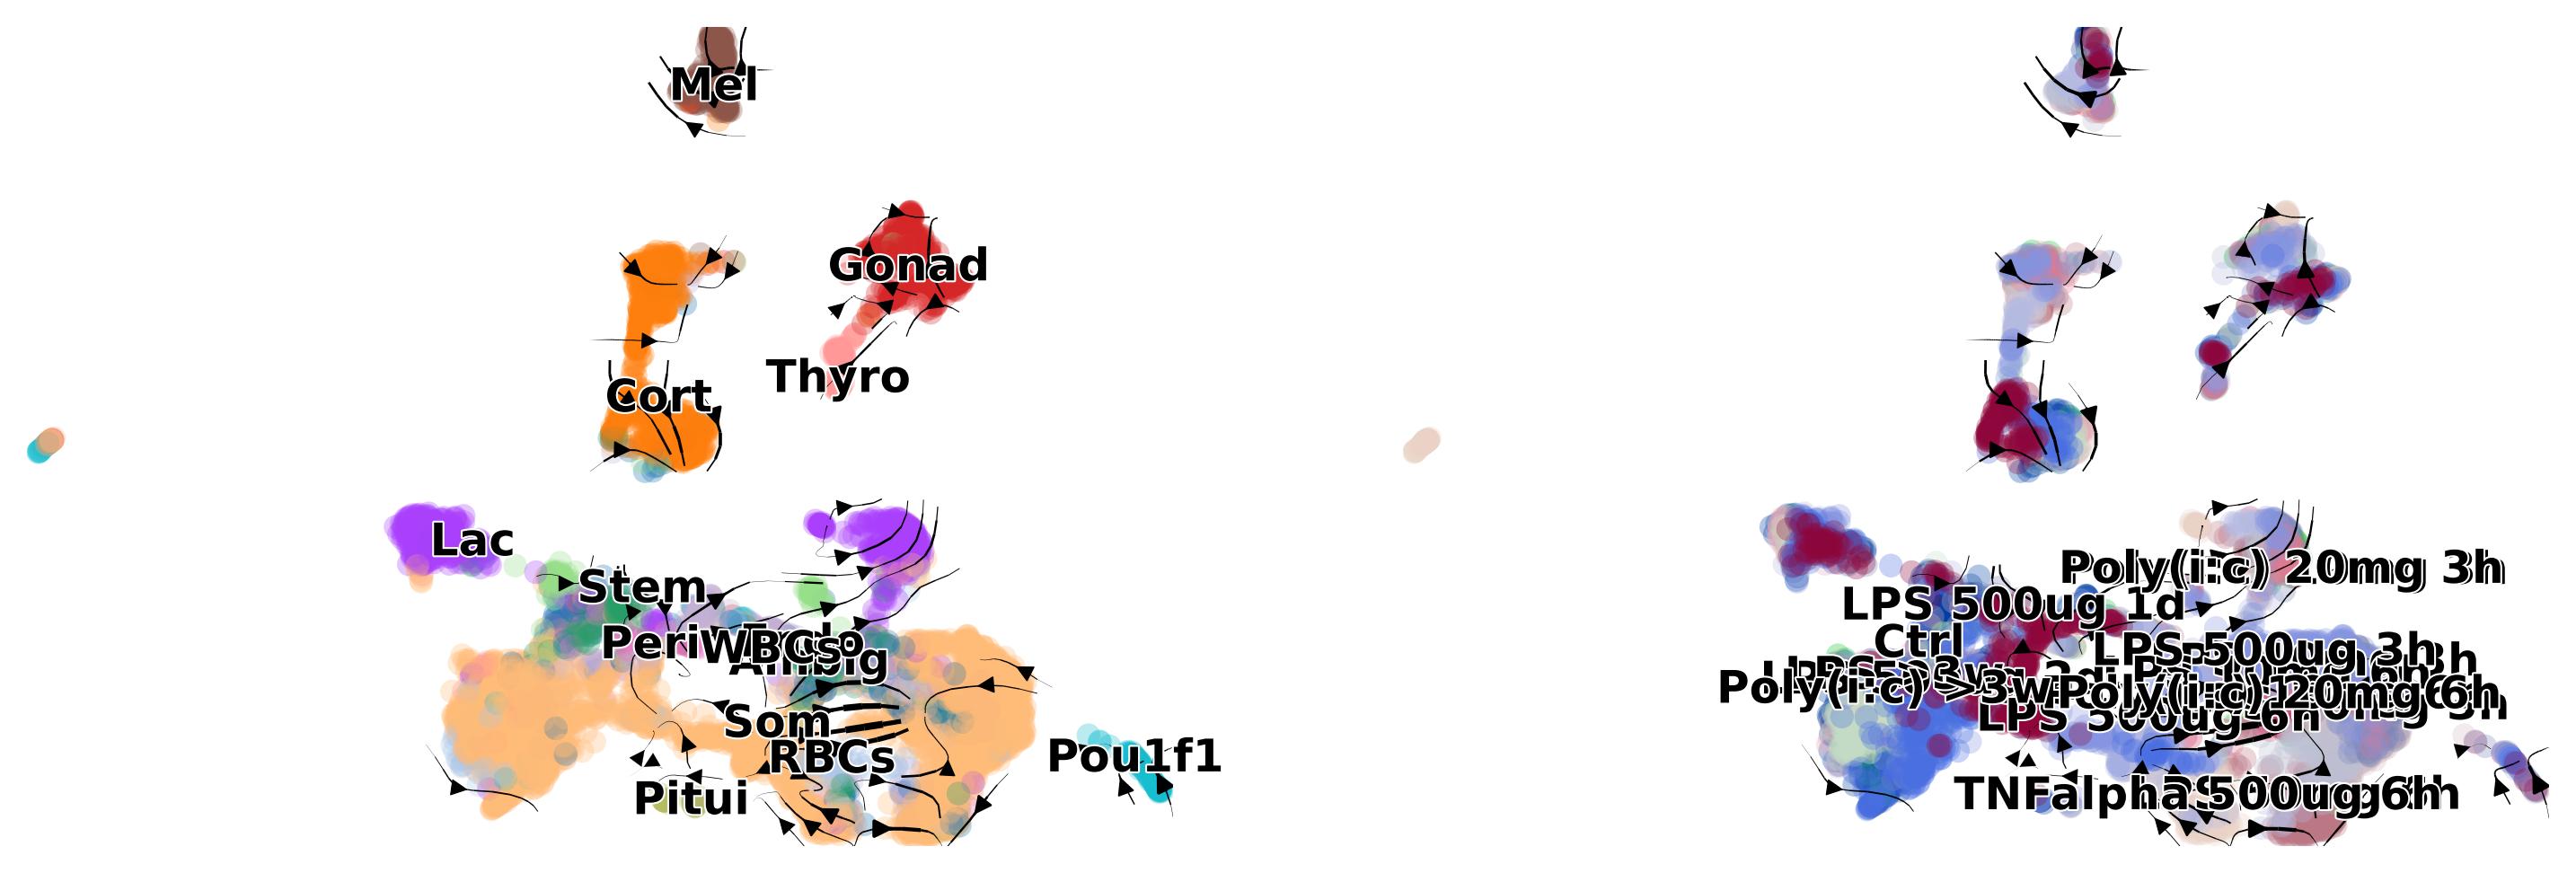

In [20]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['cell_type_brief','stim'], save='embedding_stream.pdf', title='')

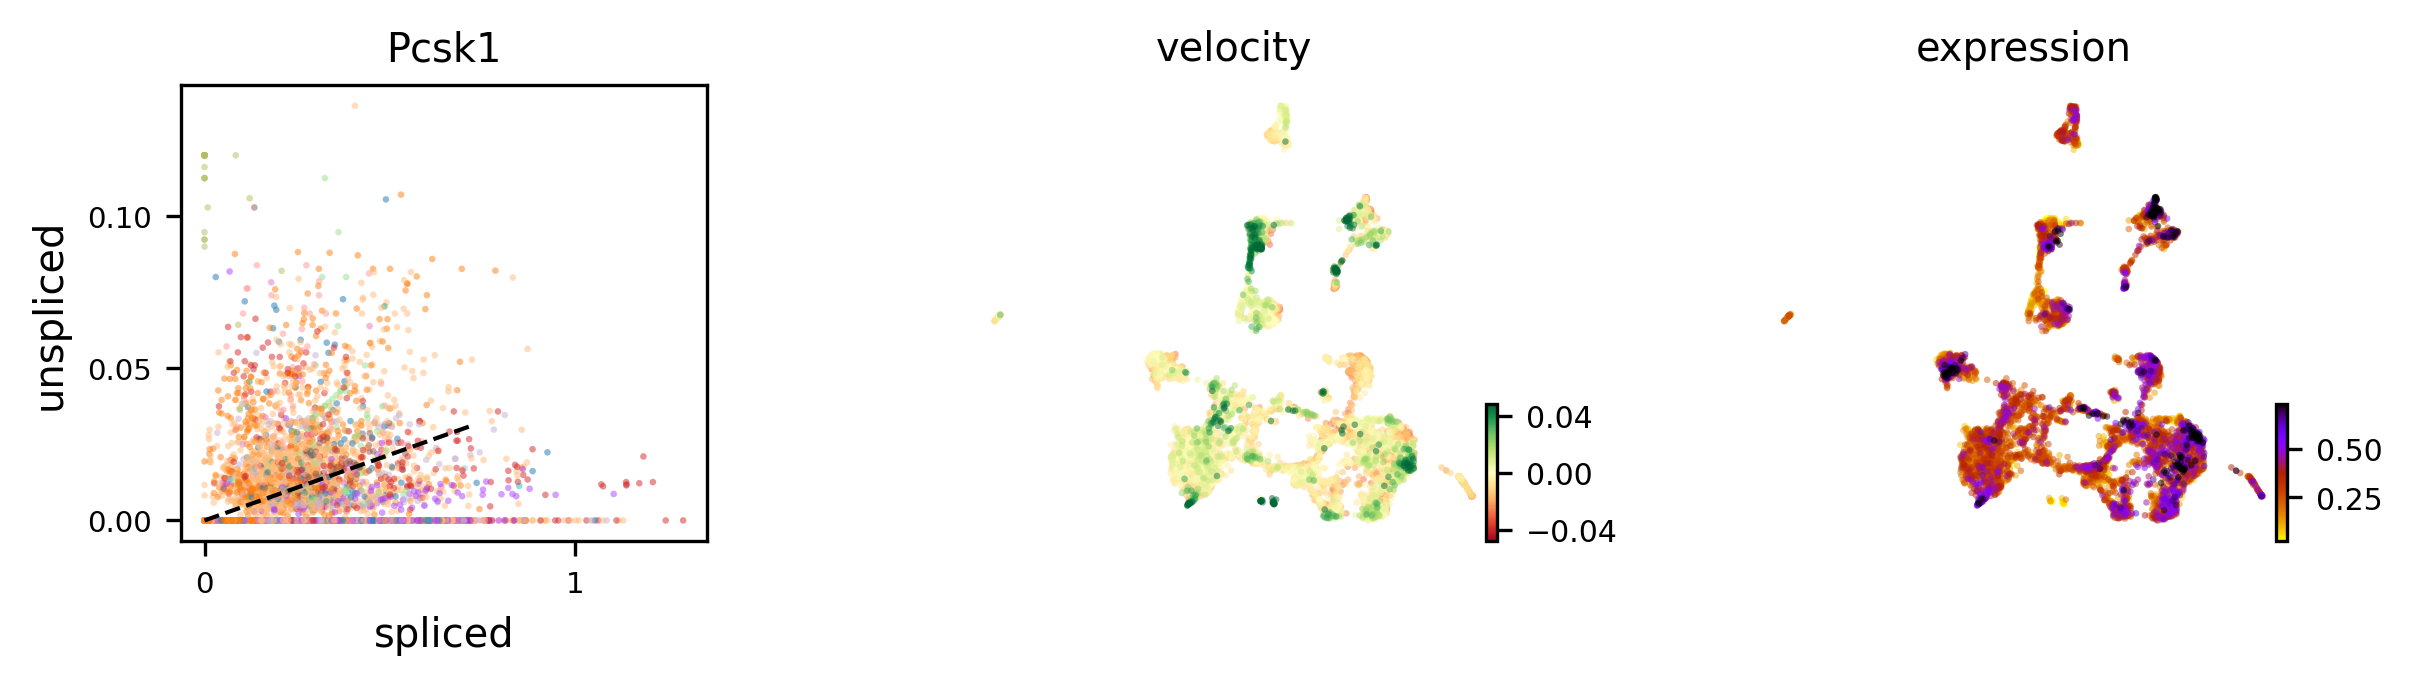

In [21]:
# plot velocity of a selected gene
scv.pl.velocity(adata, var_names=['Pcsk1'], color='cell_type_brief')

# Step 3: Downstream analysis

In [22]:
scv.tl.rank_velocity_genes(adata, groupby='cell_type_brief', min_corr=.3)

ranking velocity genes
    finished (0:00:04) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [23]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

Ambig    Cort     Endo  Gonad     Lac    Mel   Peri  Pitui  Pou1f1  \
0     Fgg   Defb1  Krtap14   Lcn2   Chrne  Oacyl    Id3  Oacyl    Tac1   
1  Cxcl11  Cxcl11      Id3  Cxcl1     Mt3  Pcsk2   Chgb     Cp   Ccl12   
2   Chrne  Ifitm6     Apoe  Ccl12    Chgb    Mt3  Pcsk2    Mt3  Cxcl11   
3    Lcn2    Saa2     Ccl4   Tac1  Ly6g6c  Ccl12  Cdca8  Pcsk2   Chrne   
4   Csta3   Cxcl1    Chrne   Ism2     Ltf   Cd86    Ltf   Ly6h    Prg4   

     RBCs     Som   Stem  Thyro   WBCs  
0  S100a8  S100a8  Defb1   Apoe  Pcsk2  
1    Prg4  Cxcl11   Ccl4   Cd74    Fga  
2  Ifitm6  Retnlg   Ly6h   Chgb  Pvalb  
3    Cd74   Cend1    Ltf   Lcn2   Apoe  
4  Hbb-bs    Prg4  Calca  Defb1    Fgg

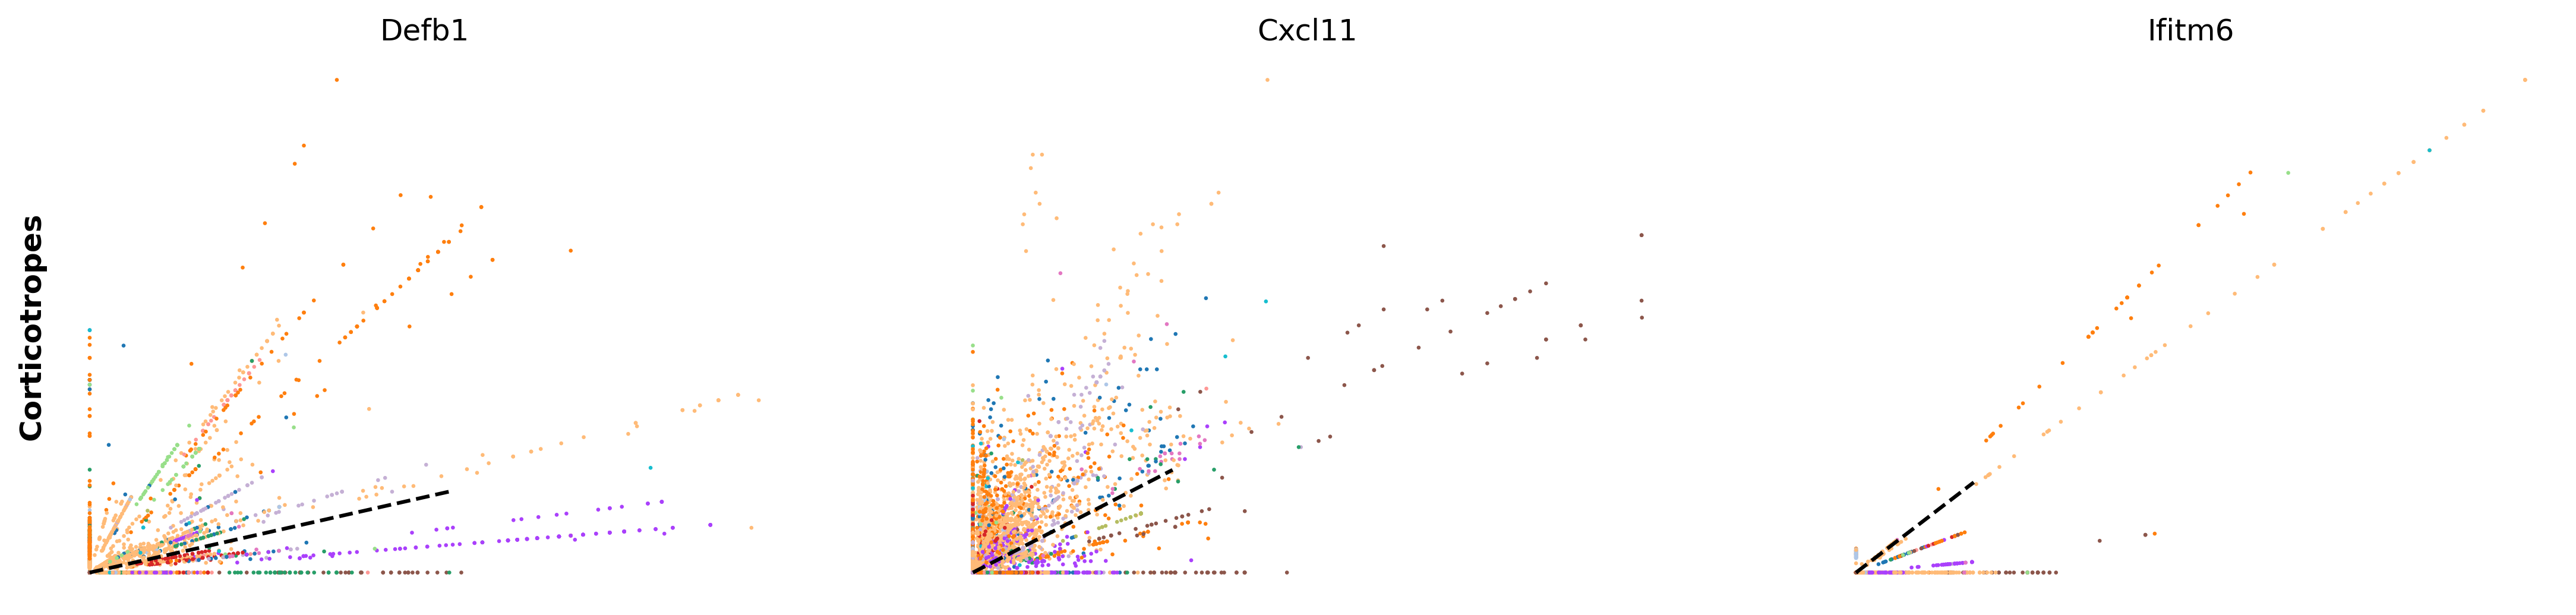

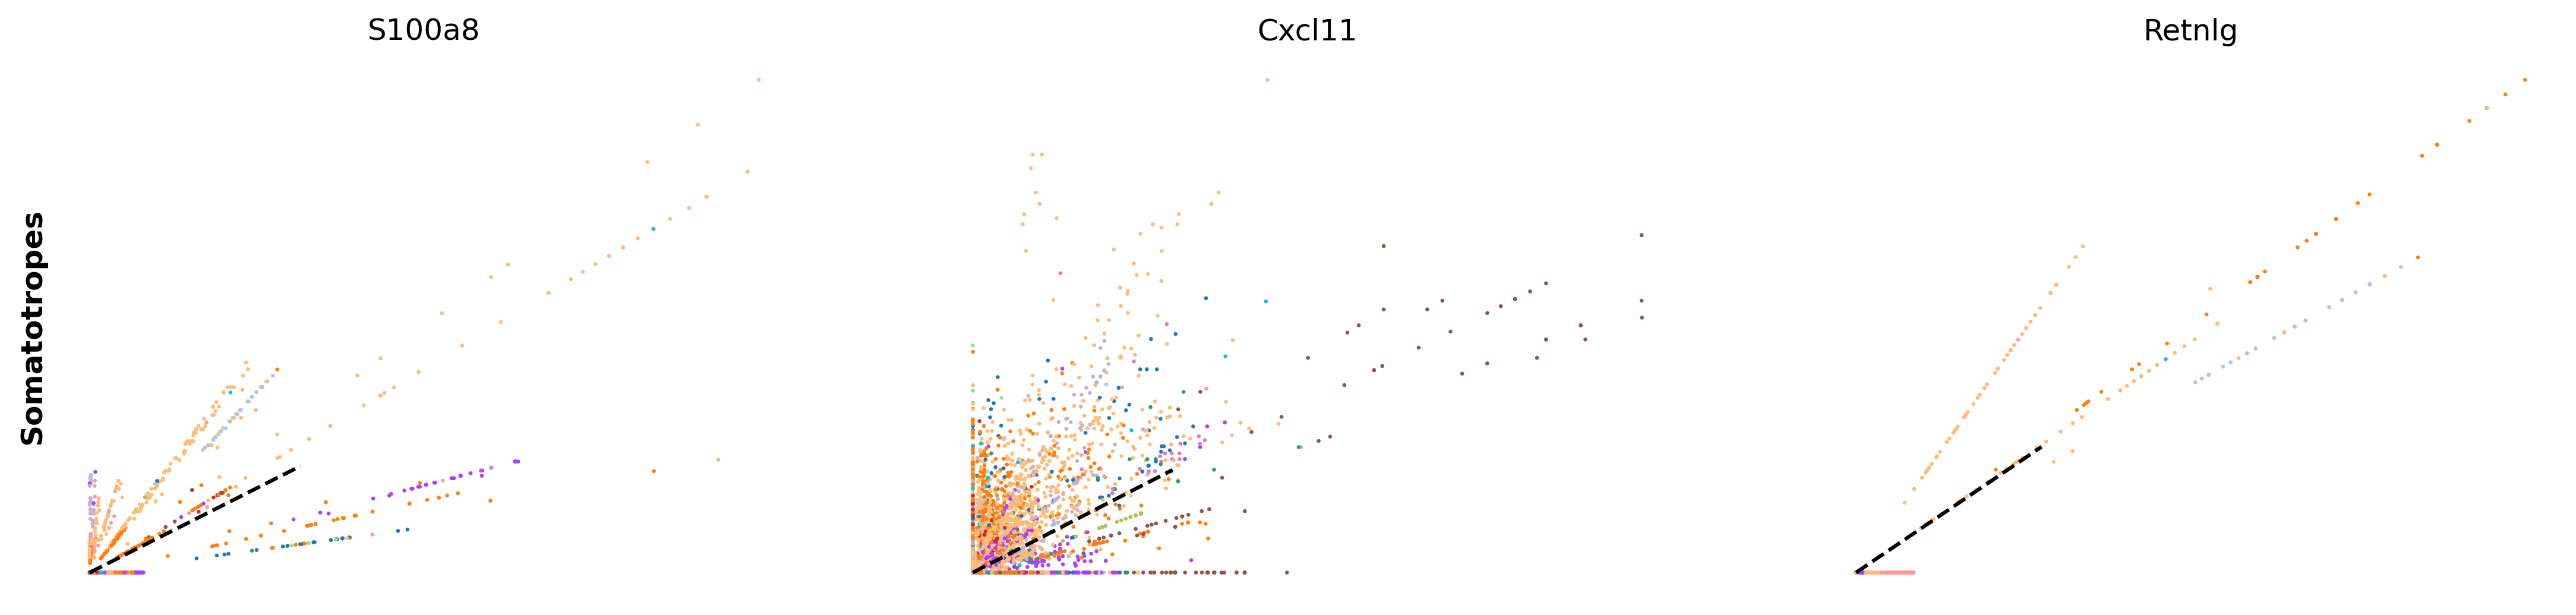

In [26]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
             add_outline='Corticotropes, Somatotropes')
scv.pl.scatter(adata, df['Cort'][:3], ylabel='Corticotropes', frameon=False, color='cell_type_brief', size=10, linewidth=1.5)
scv.pl.scatter(adata, df['Som'][:3], ylabel='Somatotropes', frameon=False, color='cell_type_brief', size=10, linewidth=1.5)

* Speed: length of the velocity vector
* Coherence: how well a velocity vector correlates to its neighbors

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


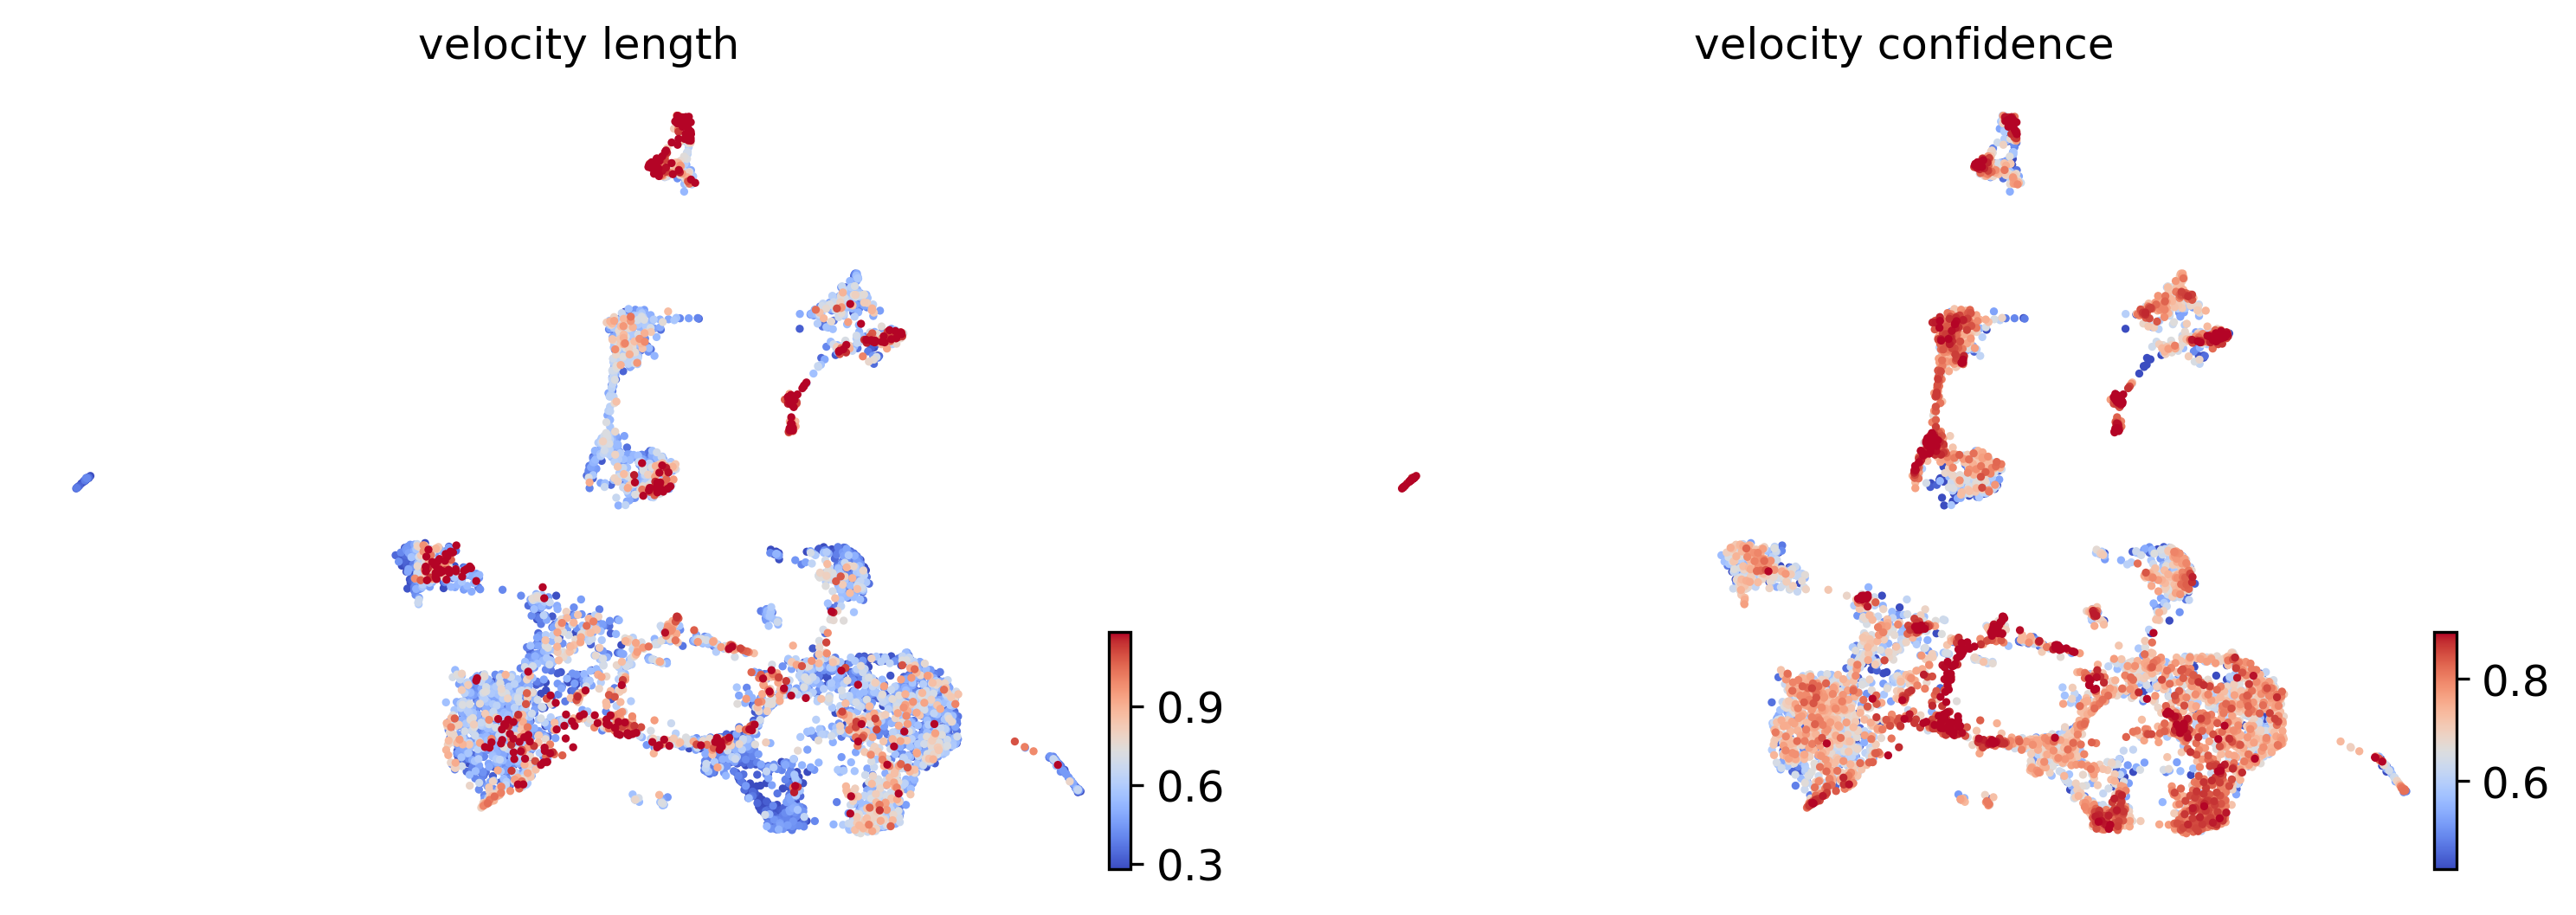

In [29]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5,95])

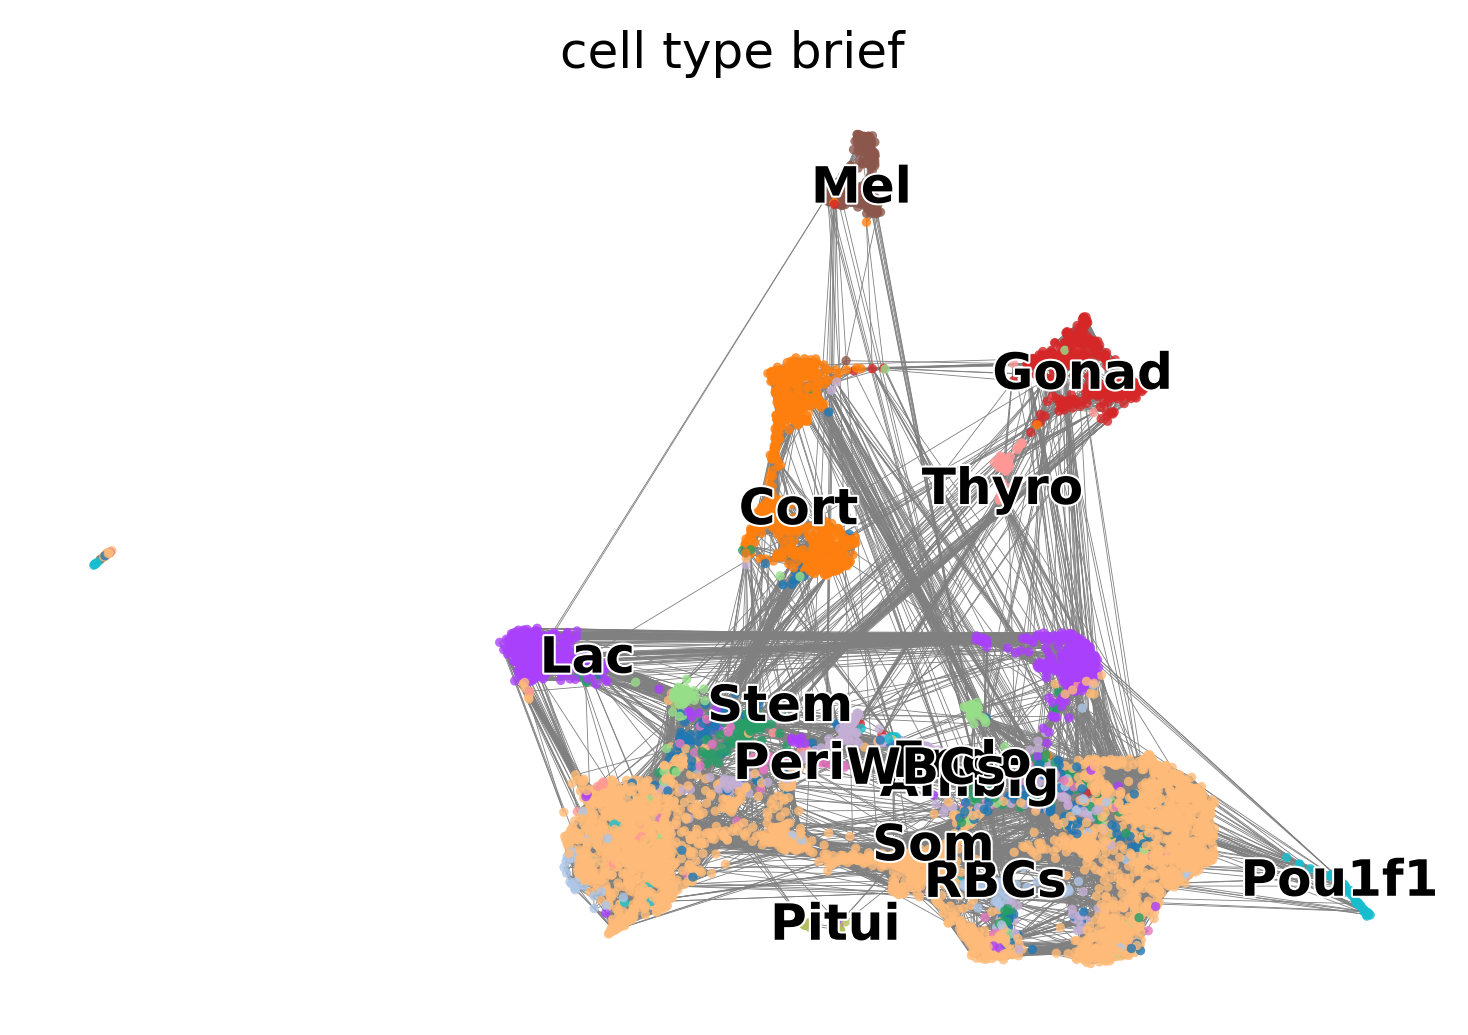

In [30]:
scv.pl.velocity_graph(adata, threshold=.1, color='cell_type_brief')

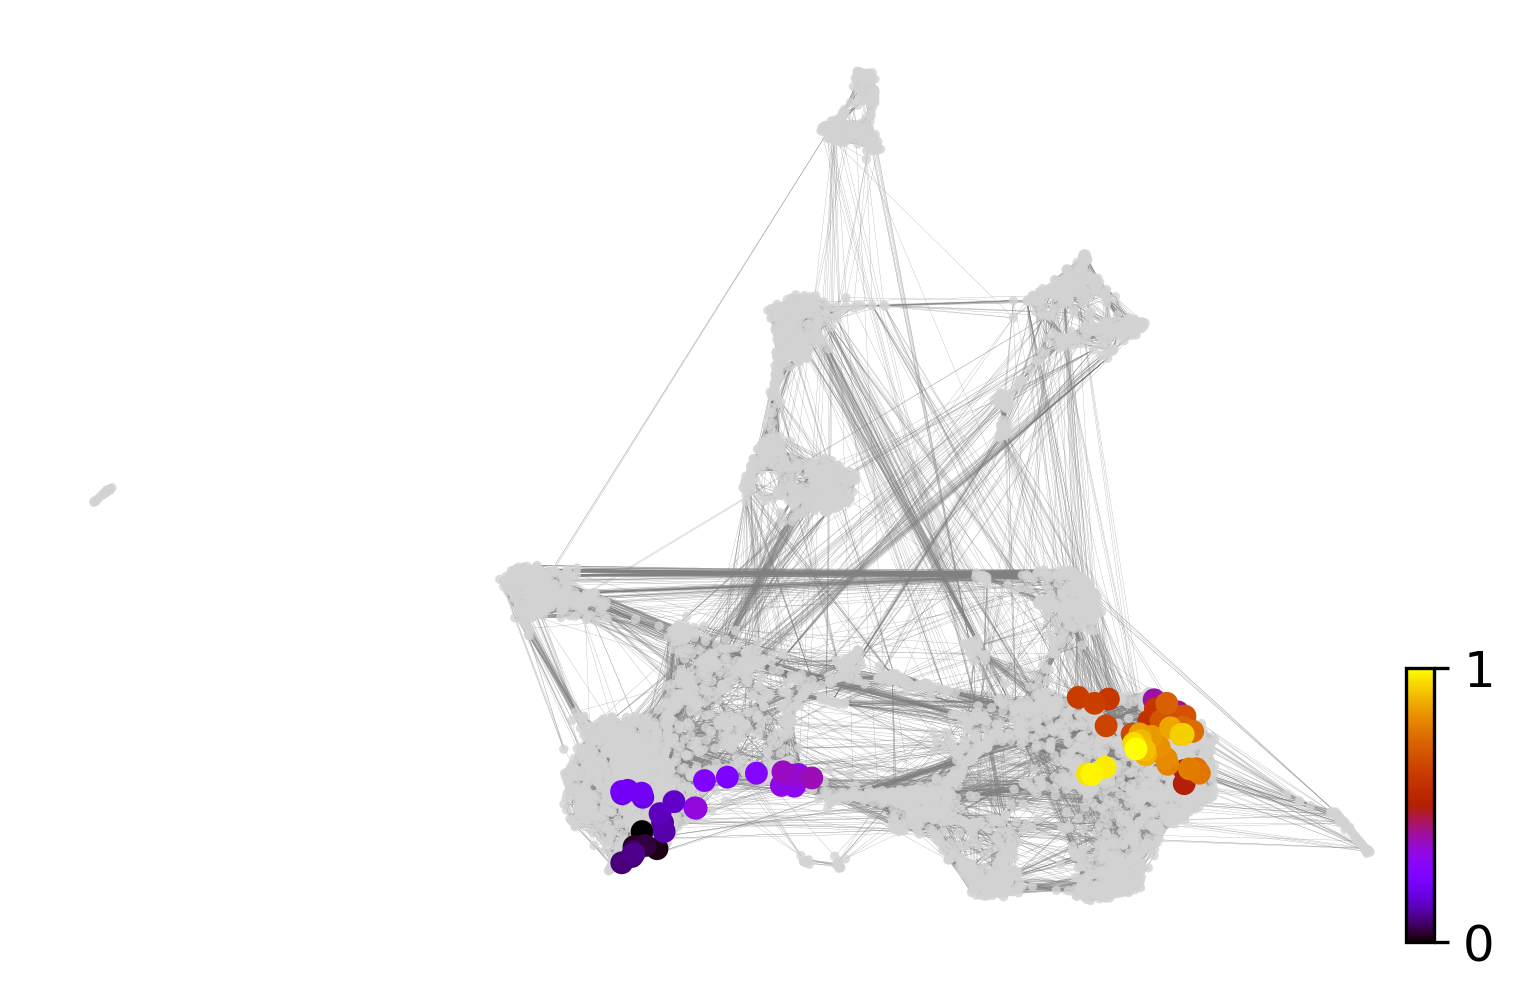

In [31]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

computing terminal states
    identified 4 regions of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


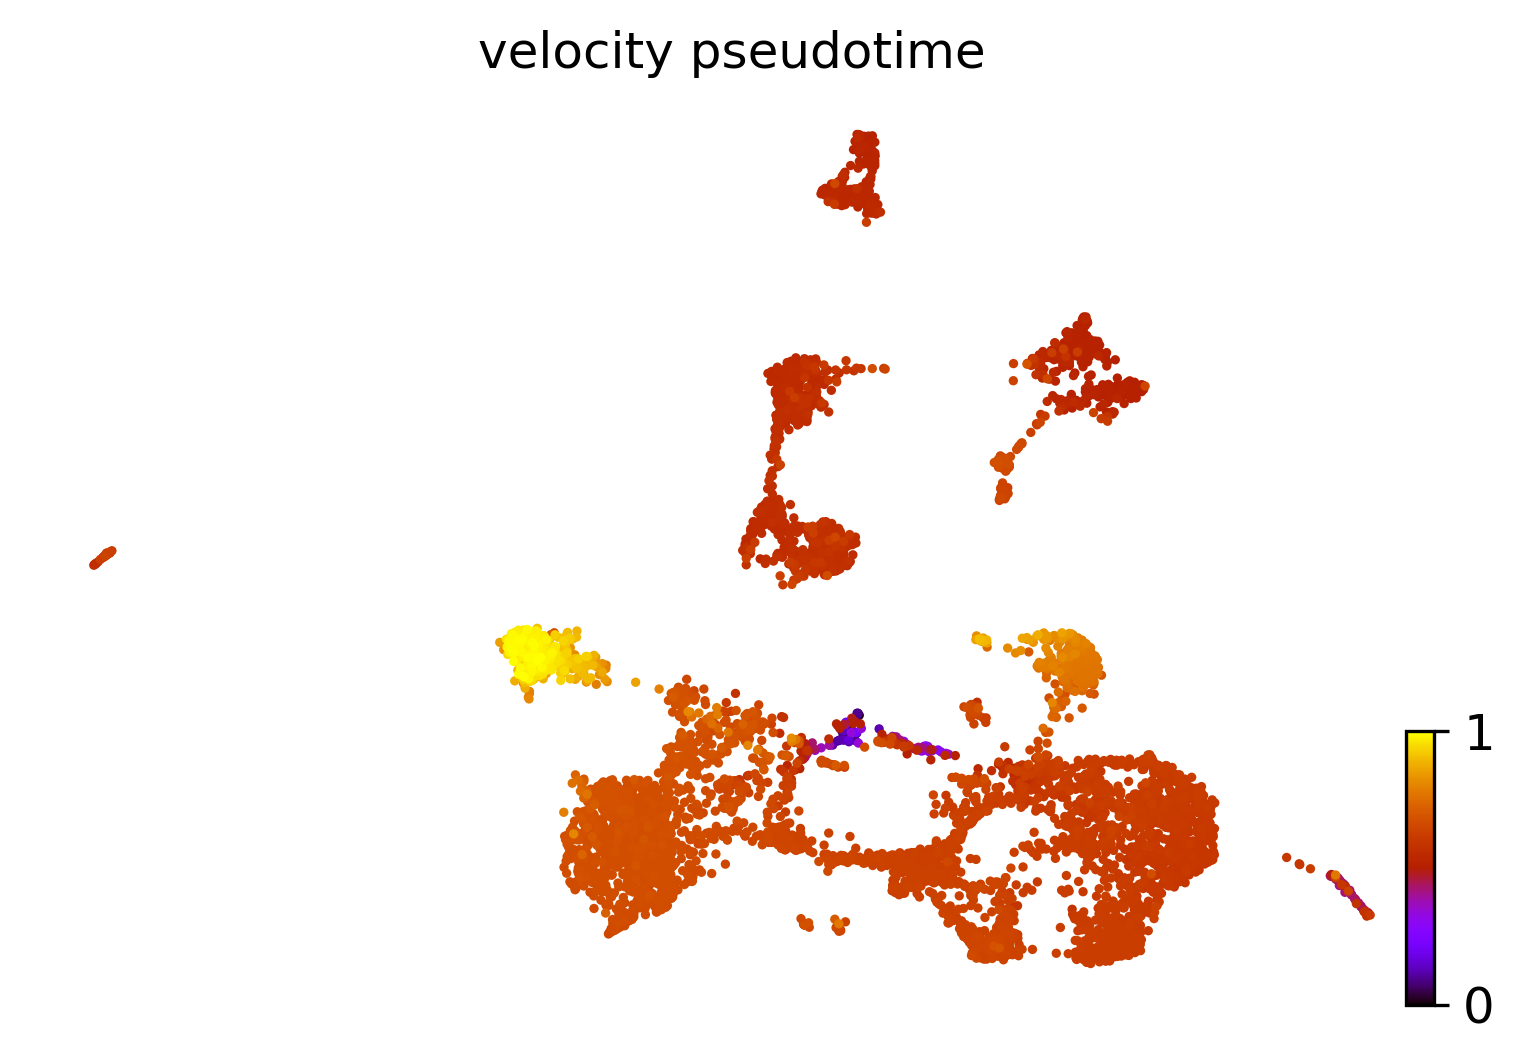

In [32]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

In [33]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

In [34]:
## BUG: no 'paga/transitions_confidence' specified
scv.tl.paga(adata, groups = 'cell_type_brief')
df = scv.get_df(adata, '../data/processed/scvelo/transitions_confidence', precision=2).T

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


OptionError: 'Pattern matched multiple keys'

In [ ]:
## BUG: no 'paga/transitions_confidence' specified
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
           min_edge_width=2, node_size_scale=1.5)

# Step 4: Analyzing a specific cell population

In [40]:
cur_celltypes = ['Cort']
adata_cort = adata[adata.obs['cell_type_brief'].isin(cur_celltypes)]

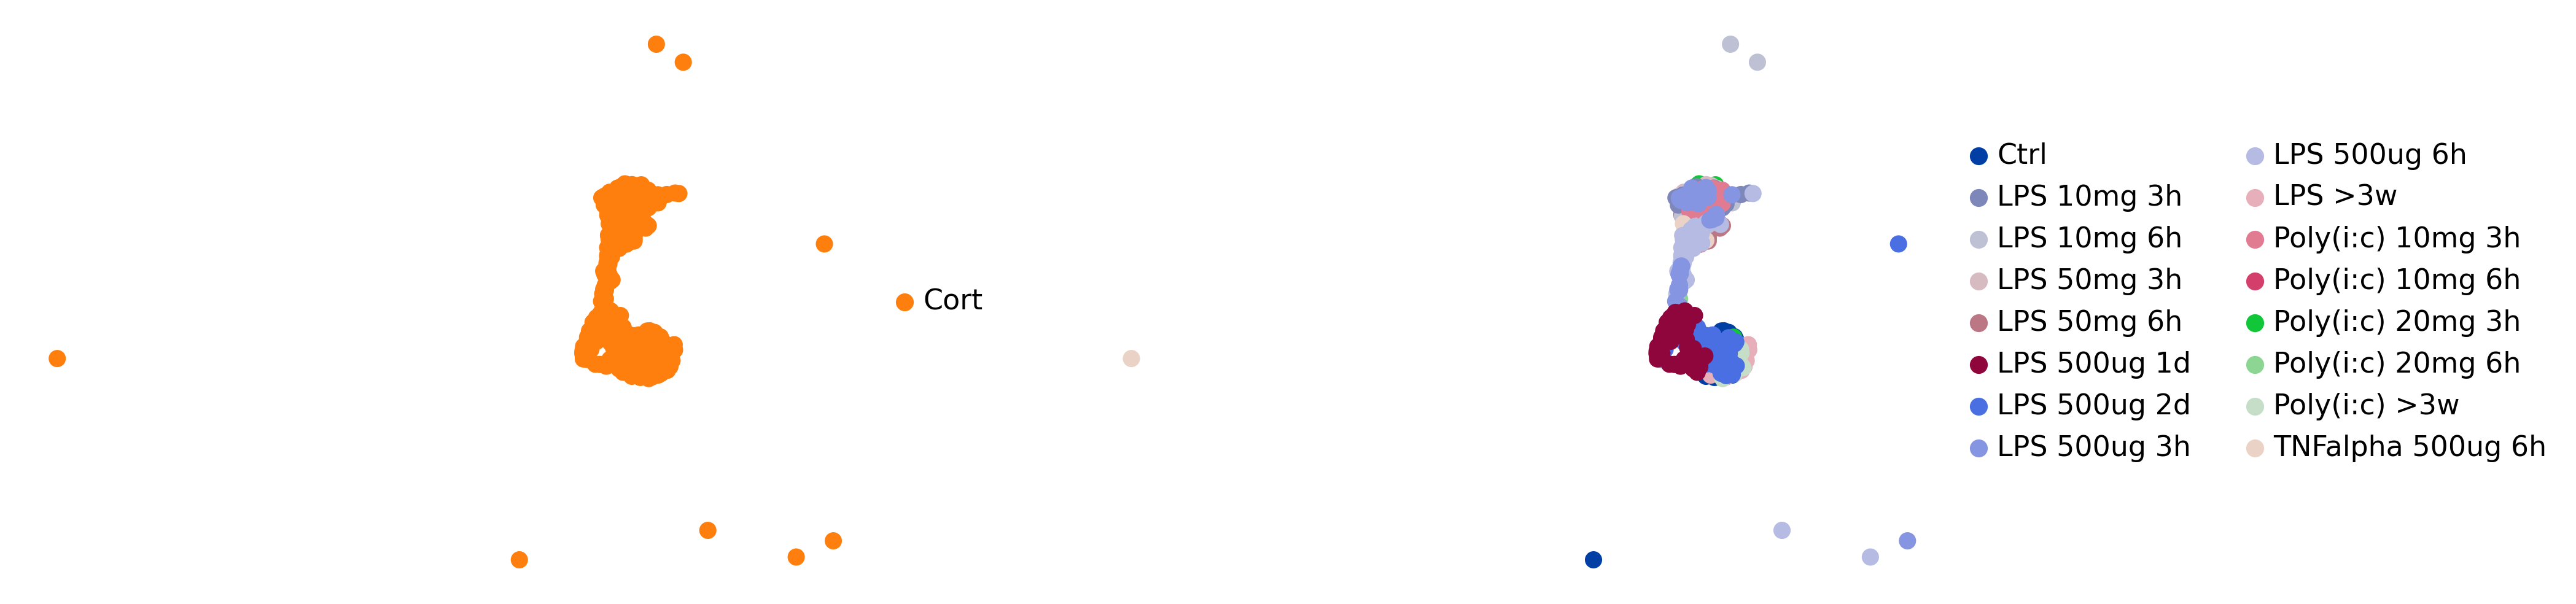

In [43]:
sc.pl.umap(adata_cort, color=['cell_type_brief','stim'], frameon=False, title=['',''])

In [44]:
sc.pp.neighbors(adata_cort, n_neighbors=15, use_rep='X_pca')

In [45]:
# pre-process
scv.pp.filter_and_normalize(adata_cort)
scv.pp.moments(adata_cort)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [46]:
scv.tl.recover_dynamics(adata_cort)

recovering dynamics (using 1/48 cores)
    finished (0:00:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [47]:
scv.tl.velocity(adata_cort, mode='dynamical')
scv.tl.velocity_graph(adata_cort)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_cort_embedding_stream.png


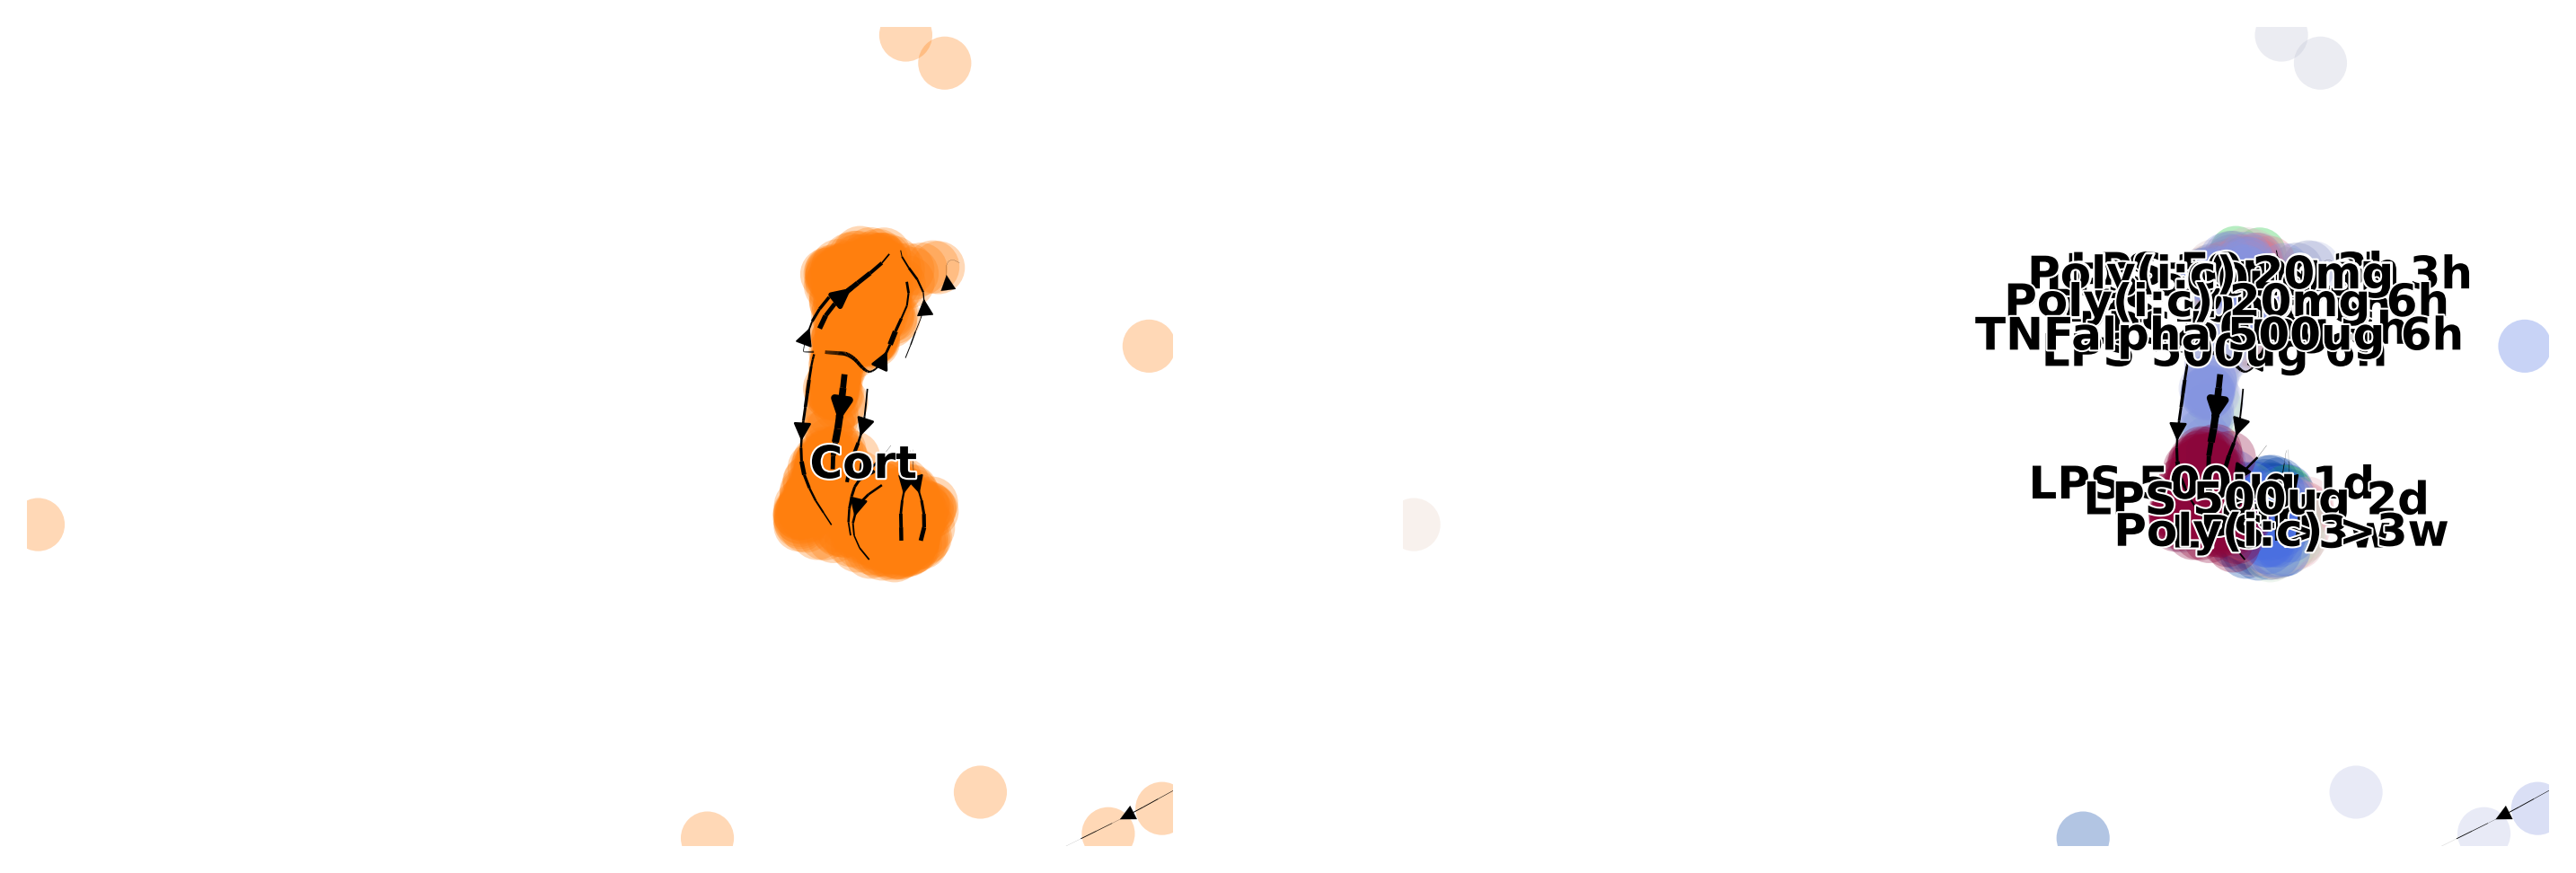

In [49]:
scv.pl.velocity_embedding_stream(adata_cort, basis='umap', color=['cell_type_brief','stim'],
                                save='cort_embedding_stream.pdf', title='')